In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import egurian_v2 as eg
import scipy as sp

In [3]:
# 1 - importação dos espectros originais | eliminação do cabeçário | passagem de todos os dados para tipo float | filtragem dos comprimentos de onda de interesse (400 a 1800 nm)
df = pd.read_csv("data.csv")
cabecario = df.iloc[:,0:4]
df = df.drop(cabecario.columns, axis = 1)
df.columns = df.columns.astype(float)
for i in df.columns:
  df[i] = df[i].astype(float)
df = df.iloc[:,290:997]

In [4]:
# 2 - Utilização da função LOEES para suavisar os espectros originais, eliminando pequenos ruídos de sinal
suave = list()
novo = np.arange(400,1802,2)
for i in df.index:
  s = eg.LOESS(df.columns.to_numpy(), df.loc[i,:].to_numpy(), novo, 15, 3 )
  suave.append(s[1])
df_suave = pd.DataFrame(suave, columns = s[0])

In [5]:
# 3 - correção da linha de base dos espectros com a função BasePolyCor
base = list()
for i in df_suave.index:
  base.append(eg.BasePolyCor(df_suave.columns.to_numpy(), df_suave.loc[i,:].to_numpy(), 4))
df_base = pd.DataFrame(base, columns = df_suave.columns)
df_base = df_base.loc[:,430:1730]

In [6]:
# 4 - normalizaçãp do sinal das amostras
normalisado = list()
for i in df_base.index:
  norma = np.linalg.norm(df_base.loc[i,:])
  normalisado.append(df_base.loc[i,:] / norma)
df_norm = pd.DataFrame(normalisado, columns = df_base.columns )
df_norm["class"] = cabecario["class"]

5 - A função RDVC3 realiza o centramento na média, mas as médias são calculadas apenas com os folds de avaliação para os ciclos internos, e com os folds de treino para os ciclos externos. A função recebe como entrada, um dataframe com todas as amostras que serão usadas para a validação, numero de ciclos externos, numero de ciclos internos, a classe que será usada como classificante das amostras e o número máximo de componentes principais testadas em cada ciclo de validação. Os outputs são os valores de erro e área sob a curva calculados em cada ciclo interno, a quantidade de pcs ótimas obtidas em cada ciclo externo, as figuras de mérito (reprodutibilidade, acurácia...), as matrizes de confusão calculadas nos ciclos externos com os folds de teste, as medianas dos scores de teste obtidos em cada ciclo externo.

In [7]:
# - Para o teste em questão, foram realizados 100 ciclos de validação cruzada, com 3 ciclos externos e 7 ciclos internos cada, avaliando no máximo 7 PCs. Os resultados obtidos foram armazenados.
# - Lista_erros: os erros obtidos nos ciclos internos (300*21)
# - lista_pcs: quantidade ótima de pcs obtidas em cada ciclo externo (300)
# - Lista_parâmetros: figuras de mérito calculadas em cada ciclo externo (300)
# - lista_confusao: matrizes de confusão obtidas em cada ciclo externo (300)
# - lista_auc: os valores de área sob a curva obtidos em cada ciclo interno (300*21)
# - lista_scores_medianas: lista das medianas dos scores obtidos com as amostras de teste em cada ciclo externo

lista_erros = list()
lista_pcs = list()
lista_parametros = list()
lista_confusao = list()
lista_auc = list()
lista_scores_medianas = list()
for i in range(0,100):
  hist_erro, hist_auc, n_pcs, params, confu, medianas = eg.RDVC3(df_norm, 3, 7, "class", 7)
  lista_erros.append(hist_erro)
  lista_scores_medianas.append(medianas)
  lista_pcs.append(n_pcs)
  lista_parametros.append(params)
  lista_confusao.append(confu)


In [8]:
# Contagem da frequencia em que cada quantidade de PCs apareceu

todos_pcs = np.hstack([i for i in lista_pcs])
histograma = [np.sum(todos_pcs == i) for i in range(1,8)]

In [9]:
# A lista de erros contem 100 listas, cada uma com 3 listas, e cada uma das 3 listas contem 7 linhas com 7 valores cada (1 a 7 componentes principais com 7 repetições cada)
# Esse comando tira a média dos erros obtidos em cada ciclo interno para cada quantidade de PCs (7 repetições cada quantidade de PCs) e armazena as médias em uma nova lista.

teste_erros = list()
for i in lista_erros:
  for j in i:
    teste_erros_int = list()
    for k in j:
      m = np.mean(k)
      teste_erros_int.append(m)
    teste_erros.append(teste_erros_int)

historico_erros_por_pc = pd.DataFrame(teste_erros)

In [10]:
# A lista com os parâmetros da matriz de confusão esta armazenada em listas da forma [TP(positivos reais), FP(positivos falsos), FN(negativos falsos), TN(negativos reais)]
# o comando abaixo realiza a soma dos parâmtros obtidos nos 3 cilos internos de cada uma das 100 repetições, e armazena em um dataframe.

teste_confusao = [j for i in range(0,len(lista_confusao)) for j in lista_confusao[i]]
historico_matriz_confusao = pd.DataFrame(teste_confusao, columns = ["TP", "FP", "FN", "TN"])
df_sum_confusao = (historico_matriz_confusao.groupby(historico_matriz_confusao.index // 3).sum())

Text(0.5, 1.0, 'Quantidade Ótima de PCs')

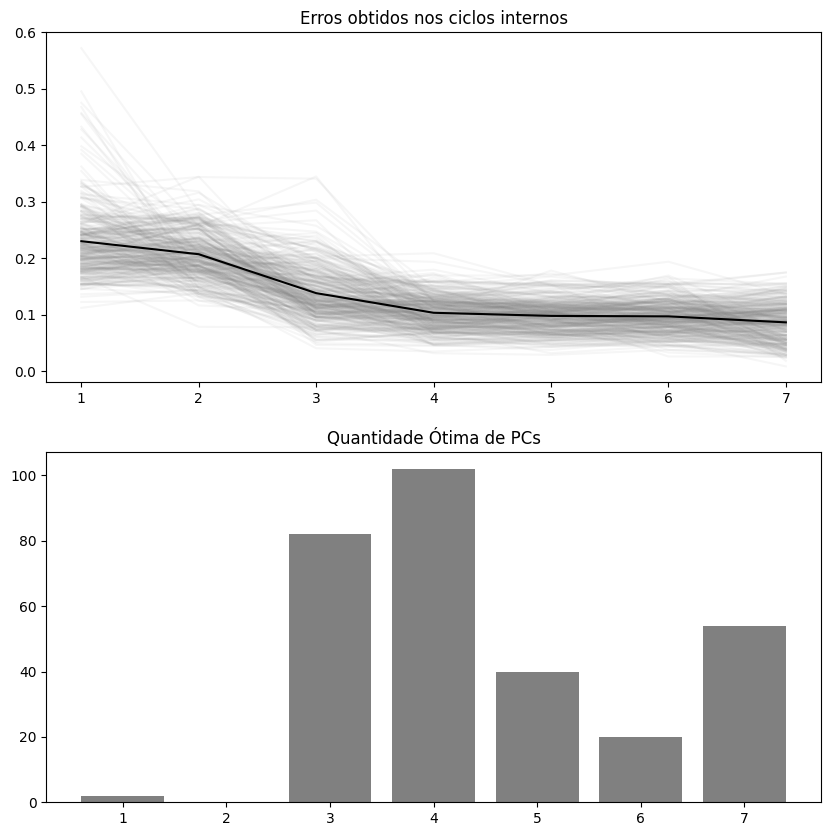

In [11]:
# Plot dos erros para cada quantidade de pc obtido em cada ciclo externo e do histograma da quantidade de PCs ótimas
# OBSERVA-SE QUE 4 PCs É A QUANTIDADE QUE ENTREGOU MAIOR OCERRÊNCIA DE ÓTIMO DE ACORDO COM OS TREINOS DA RDCV

figura1, axis = plt.subplots(2,1, figsize = (10,10))

for i in historico_erros_por_pc.index:
  axis[0].plot(list(range(1,8)),historico_erros_por_pc.loc[i,:], color = "grey", alpha = 0.07)
axis[0].plot(list(range(1,8)),historico_erros_por_pc.mean(), color = "black")
axis[0].set_title("Erros obtidos nos ciclos internos")

axis[1].bar(list(range(1,8)), histograma, color = "grey")
axis[1].set_title("Quantidade Ótima de PCs")

plt.show()

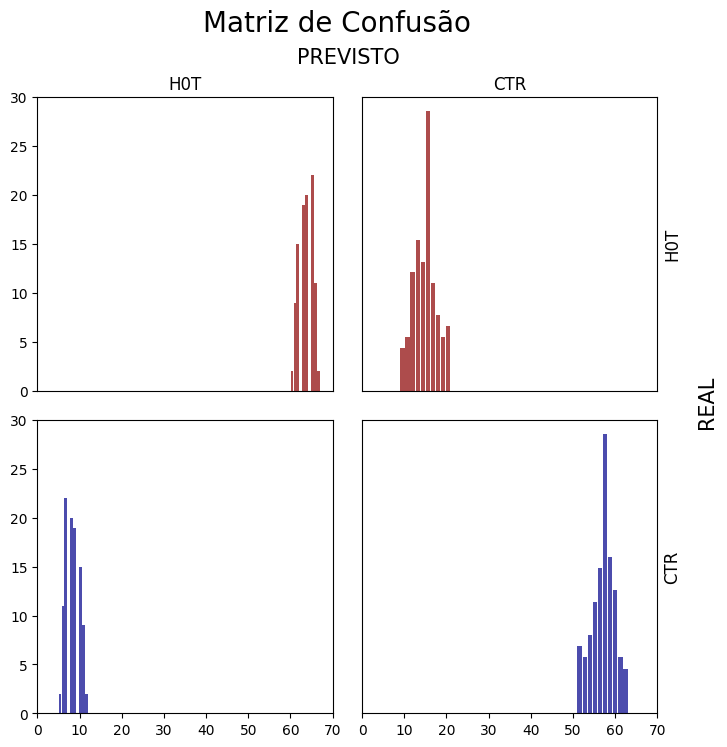

In [12]:
# Plot da Matriz de confusão: sumariza a quantidade de "acertos e erros" dem cada uma das 100 repetições. Essa matriz é feita para cada repetição, e não por ciclo externo
# SUperior esquerdo : Positivos reais
# Superior direito: Positivos falsos
# Inferior esquedo: Negativos falsos
# Inferior direito: Negativos reais

figura2, axis = plt.subplots(2, 2, figsize = (8,8))
figura2.subplots_adjust(hspace = 0.1, wspace = 0.1)


axis[0,0].hist(df_sum_confusao["TP"], align = "mid", color = "darkred", rwidth= 0.9, alpha = 0.7)
axis[0,0].set_xlim(0,70)
axis[0,0].set_ylim(0,30)
axis[0,0].set_xticks([])
axis[0,0].set_title("H0T")
axis[1,0].hist(df_sum_confusao["FN"], align = "mid", color = "darkblue", rwidth= 0.9, alpha = 0.7)
axis[1,0].set_xlim(0,70)
axis[1,0].set_ylim(0,30)
axis[0,1].hist(df_sum_confusao["FP"], align = "mid", color = "darkred", rwidth= 0.9, alpha = 0.7)
axis[0,1].set_xlim(0,70)
axis[0,1].set_xticks([])
axis[0,1].set_yticks([])
axis[0,1].set_title("CTR")
axis[0,1].yaxis.set_label_position("right")
axis[0,1].set_ylabel("H0T", size = 12)
axis[1,1].hist(df_sum_confusao["TN"], align = "mid", color = "darkblue", rwidth= 0.9, alpha = 0.7)
axis[1,1].set_xlim(0,70)
axis[1,1].set_yticks([])
axis[1,1].yaxis.set_label_position("right")
axis[1,1].set_ylabel("CTR", size = 12)

figura2.text(0.45, 0.93, "PREVISTO", va="center", fontsize=15)
figura2.text(0.95, 0.5,  "REAL", va="center", rotation = "vertical", fontsize=15)

figura2.suptitle("Matriz de Confusão", y=0.99, fontsize = 20)

plt.show()


In [13]:
# Figuras de mérito

# cálculo da média geral das figuras de mérito obtidas em cada ciclo externo
lista_FOM = [np.mean(lista_parametros[i], axis = 0) for i in range(0,len(lista_parametros))]
lista_FOM_medias = np.mean(lista_FOM, axis = 0)

# cálculo do desvio padrão de cada figura de mérito
lista_FOM_depa = np.std(lista_FOM, axis = 0, ddof = 1)

# cálculo dos intervalos de confiança
t_valor = sp.stats.t.ppf(0.975,99)
intervalos_C_s =  lista_FOM_medias + (t_valor * (lista_FOM_depa/(100**0.5)))
intervalos_C_i =  lista_FOM_medias - (t_valor * (lista_FOM_depa/(100**0.5)))

# tabela das figuras de mérito
pd.DataFrame({"Médias": lista_FOM_medias, "Limite Superior": intervalos_C_s, "Limite Inferior": intervalos_C_i, "Desv_pad": lista_FOM_depa }, index = ["Repdodutibilidade","Especificidade","Acuracia","PPV","NPV","AUC"])

,Médias,Limite Superior,Limite Inferior,Desv_pad
Repdodutibilidade,0.884167,0.888671,0.879663,0.022699
Especificidade,0.792639,0.800156,0.785122,0.037883
Acuracia,0.838403,0.842459,0.834347,0.020440
PPV,0.816599,0.822212,0.810985,0.028292
NPV,0.876747,0.881008,0.872486,0.021474
AUC,0.897546,0.900953,0.894140,0.017168


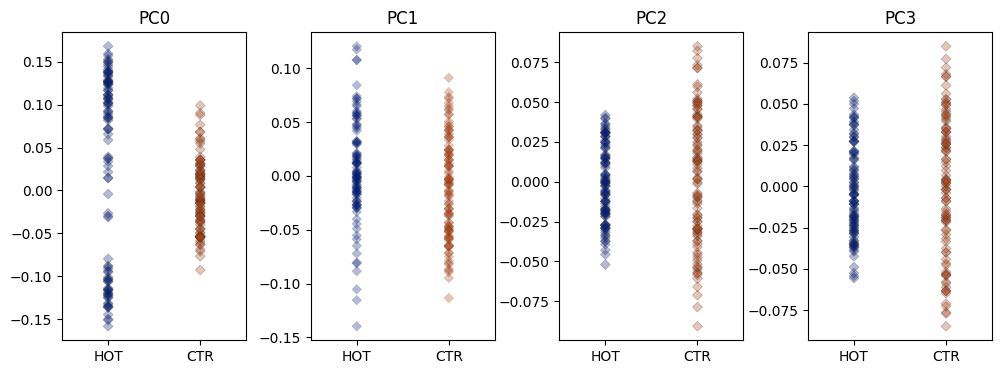

In [45]:
# Filtragem das medianas dos scores obtidos nos ciclos externos em que a quantidade ótima de PCs usada foi 4 (quantidade com maior frequência no histograma)
teste_medianas = list()
for i in range(0,len(lista_scores_medianas)):
  for j in range(0,len(lista_scores_medianas[i])):
    if lista_scores_medianas[i][j][-1] == 4:
      teste_medianas.append(lista_scores_medianas[i][j])

lista_HOT_med = list([] for i in range(0,4))
for i in range(0,len(teste_medianas)):
  for j in range(0,len(teste_medianas[i][0])):
    lista_HOT_med[j].append(teste_medianas[i][0][j])

lista_CTR_med = list([] for i in range(0,4))
for i in range(0,len(teste_medianas)):
  for j in range(0,len(teste_medianas[i][1])):
    lista_CTR_med[j].append(teste_medianas[i][1][j])


# Organização das medianas em um dataframe
df_HOT_med = pd.DataFrame(lista_HOT_med, index =["PC0","PC1","PC2","PC3"], columns = len(df_HOT_med)*["HOT"]).T
df_CTR_med = pd.DataFrame(lista_CTR_med, index =["PC0","PC1","PC2","PC3"], columns = len(df_CTR_med)*["CTR"]).T
df_medianas = pd.concat([df_HOT_med, df_CTR_med])
df_medianas.reset_index(inplace = True)
df_medianas.columns = ["class","PC0","PC1","PC2","PC3"]

# Plot das medianas dos scores obtidos com os folds de teste (apenas com PCs = 4)
# Figura exibida para avaliar se apenas as os scores tem capacidade de distinguir entre os grupos "HOT" e "CTR", nota-se pouda distinção entre elas para todas as PCs
figura3, axis = plt.subplots(1,4, figsize = (12,4))
figura3.subplots_adjust(wspace = 0.35)
sns.stripplot(data = df_medianas, y = "PC0", x = "class", hue = "class", palette = "dark", marker = "D", jitter = False, linewidth= 0.5, alpha = 0.3, ax = axis[0])
sns.stripplot(data = df_medianas, y = "PC1", x = "class", hue = "class", palette = "dark", marker = "D", jitter = False, linewidth= 0.2, alpha = 0.3, ax = axis[1])
sns.stripplot(data = df_medianas, y = "PC2", x = "class", hue = "class", palette = "dark", marker = "D", jitter = False, linewidth= 0.5, alpha = 0.3, ax = axis[2])
sns.stripplot(data = df_medianas, y = "PC3", x = "class", hue = "class", palette = "dark", marker = "D", jitter = False, linewidth= 0.5, alpha = 0.3, ax = axis[3])
axis[0].set(xlabel = "", ylabel = "", title = "PC0")
axis[1].set(xlabel = "", ylabel = "", title = "PC1")
axis[2].set(xlabel = "", ylabel = "", title = "PC2")
axis[3].set(xlabel = "", ylabel = "", title = "PC3")
plt.show()

In [17]:
# Calculo da PCA , em seguida cálculo da LDA com as 4 primeiras componentes principais obtidas na PCA.

#df_norm.drop(["class"], axis = 1, inplace = True)
mu = df_norm.mean()
df_centr = df_norm - mu
U, s, Vh = np.linalg.svd(df_centr)
#s**2/(np.sum(s**2))
scores = U[:,:4]*s[:4]
df_scores = pd.DataFrame(scores)
df_scores["class"] = cabecario["class"]

Sw, Sb, LDA = eg.LDAcalc(df_scores, "class",[0,1,2,3])
w = LDA.iloc[0,:]
LDA_scores = df_scores.iloc[:,0:-1].dot(w)
df_scores["LDA"] = LDA_scores.values

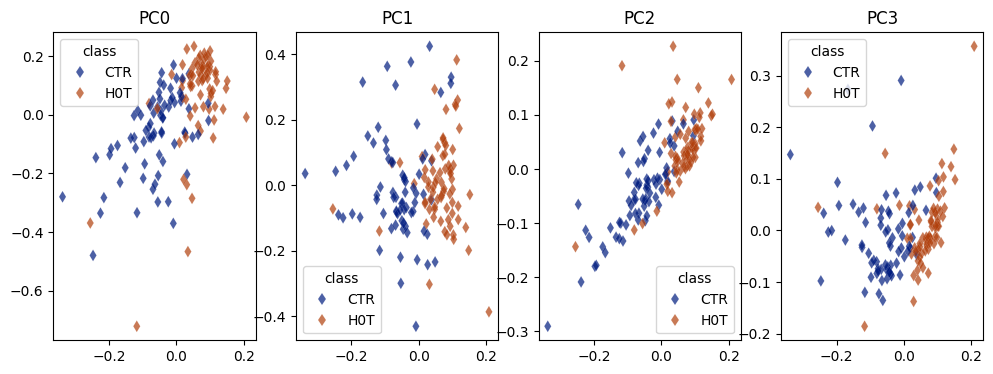

In [42]:
# Plot dos scores das 4 primeiras PCs(y) vs LDA calculada com as 4 primeiras PCs(x)
figura4, axis = plt.subplots(1,4, figsize = (12,4))
sns.scatterplot(data = df_scores, x = "LDA", y = 0, hue = "class", ax = axis[0], palette = "dark", marker = "d", alpha = 0.7, linewidth = 0.1)
axis[0].set(xlabel = "", ylabel = "", title = "PC0")
sns.scatterplot(data = df_scores, x = "LDA", y = 1, hue = "class", ax = axis[1], palette = "dark", marker = "d", alpha = 0.7, linewidth = 0.1)
axis[1].set(xlabel = "", ylabel = "", title = "PC1")
sns.scatterplot(data = df_scores, x = "LDA", y = 2, hue = "class", ax = axis[2], palette = "dark", marker = "d", alpha = 0.7, linewidth = 0.1)
axis[2].set(xlabel = "", ylabel = "", title = "PC2")
sns.scatterplot(data = df_scores, x = "LDA", y = 3, hue = "class", ax = axis[3], palette = "dark", marker = "d", alpha = 0.7, linewidth = 0.1)
axis[3].set(xlabel = "", ylabel = "", title = "PC3")

plt.show()

CONCLUSÃO: O objetivo do estudo era verificar a capacidade de um modelo baseado em PCA - LDA classificar corretamente amostras de sangue de pacientes com carcinoma (HOT) e saudáveis (CTR). Para isso os autores usaram a validação cruzada RDCV, aonde as amostras são divididas em 3 geupos, e cada amostra serve como teste uma vez enquanto as outras duas servem como treino. Ou seja, o modelo de classificação é construído com 2 grupos de amostras e testado no grupo externo (teste), como se este fosse uma leva de amostras desconhecidas que é submetida ao modelo de classificação.
As principais informações obtidas com a validação cruzada são: nº de PC, acurácia, reprodutibilidade e especificidade do modelo. No estudo em questão a quantidade ótima de PCs que eu obtive foi 4 (mesma dos autores) Acurácia de 0,83 (autores 0,81), especificidade de 0,79 (autores 0,75) e replodutibilidade de 0,88.
De forma geral, meus resultados foram similares aos resultados dos autores. Entretanto, se eu fosse utilizar o modelo proposto para classificar amostras desconhecidas, usaria 10 PCs. Mesmo que a quantidade ótima obtida nesse estudo (e pelos autores) foi 4, nota-se nos resultados preliminares que o tratamento utilizando 10 PC's entregou melhor distinção e menos outliers para todas as 10 PCs. Acredito que o método 1-SE para escolha da melhor quantidade de PCs acabou deixando informação relevante para trás.   